#### Lab 3.1 (Opzionale)

#### Partire da qualsiasi tipo di dato testuale (corpus, dataframe di similarità, dataset generico, …)
#### • Costruzione di un grafo, e implementazione di un semplice meccanismo per
#### • Visualizzare dati testuali
#### • Trovare le giuste informazioni (IR, disambiguazione)
#### • Summarization
#### • Anticipazione nuove domande


In [41]:
import pandas as pd
import re
import spacy
from spacy.tokens import Span
from spacy.matcher import Matcher
import networkx as ntx
import matplotlib.pyplot as plt
import numpy as np
import math 
from scipy.spatial import distance

In [42]:
nlp = spacy.load('en_core_web_lg')

In [43]:
data = pd.read_csv('example2.csv')
data['text']
data.shape

doc = nlp(data['text'][10])

#nel testo voglio trovare soggetto e oggetto. 
for token in doc:
    print(token.text, "-->", token.dep_)

In --> prep
artificial --> amod
neural --> amod
networks --> pobj
, --> punct
the --> det
activation --> compound
function --> nsubj
of --> prep
a --> det
node --> pobj
defines --> ROOT
the --> det
output --> dobj
of --> prep
that --> det
node --> pobj
given --> prep
an --> det
input --> dobj
or --> cc
set --> conj
of --> prep
inputs --> pobj
. --> punct

 --> dep
A --> det
standard --> amod
integrated --> amod
circuit --> nsubjpass
can --> aux
be --> auxpass
seen --> ROOT
as --> prep
a --> det
digital --> amod
network --> pobj
of --> prep
activation --> compound
functions --> pobj
that --> nsubj
can --> aux
be --> relcl
" --> punct
ON --> attr
" --> punct
( --> punct
1 --> appos
) --> punct
or --> cc
" --> punct
OFF --> conj
" --> punct
( --> punct
0 --> appos
) --> punct
, --> punct
depending --> prep
on --> prep
input --> pobj
. --> punct
This --> nsubj
is --> ROOT
similar --> acomp
to --> prep
the --> det
linear --> amod
perceptron --> pobj
in --> prep
neural --> amod
networks --> 

In [44]:
data

,Unnamed: 0,page,text,link,categories,topic
0,0,Machine Learning,Machine learning (ML) is a field of inquiry de...,https://en.wikipedia.org/wiki/Machine_learning,"['All articles with unsourced statements', 'Ar...",Machine Learning
1,1,AAAI Conference on Artificial Intelligence,The AAAI Conference on Artificial Intelligence...,https://en.wikipedia.org/wiki/AAAI_Conference_...,"['Articles with VIAF identifiers', 'Articles w...",Machine Learning
2,2,ACM Computing Classification System,The ACM Computing Classification System (CCS) ...,https://en.wikipedia.org/wiki/ACM_Computing_Cl...,"['1964 in computing', 'All stub articles', 'Ar...",Machine Learning
3,3,ACM Computing Surveys,ACM Computing Surveys is a quarterly peer-revi...,https://en.wikipedia.org/wiki/ACM_Computing_Su...,"['All stub articles', 'Articles with short des...",Machine Learning
4,4,ADALINE,ADALINE (Adaptive Linear Neuron or later Adapt...,https://en.wikipedia.org/wiki/ADALINE,"['All articles with dead external links', 'Art...",Machine Learning
...,...,...,...,...,...,...
170,170,David Silver (computer scientist),David Silver (born 1976) is a British compute...,https://en.wikipedia.org/wiki/David_Silver_(co...,"['1970s births', 'Academics of University Coll...",Machine Learning
171,171,Decision support system,A decision support system (DSS) is an informat...,https://en.wikipedia.org/wiki/Decision_support...,"['All articles with unsourced statements', 'Ar...",Machine Learning
172,172,Decision making,"In psychology, decision-making (also spelled d...",https://en.wikipedia.org/wiki/Decision-making,"['All articles lacking reliable references', '...",Machine Learning
173,173,DeepDream,DeepDream is a computer vision program created...,https://en.wikipedia.org/wiki/DeepDream,"['2015 software', 'Algorithmic art', 'Articles...",Machine Learning


In [45]:
#estraggo le entities che sono 2, ovvero saranno i nodi del KG collegati dalle relazioni. Vediamo che spesso ci possono essere delle parole composte come "vino rosso"
def extract_entities(sents):
   # chunk one
   enti_one = ""
   enti_two = ""
  
   dep_prev_token = "" # dependency tag of previous token in sentence
  
   txt_prev_token = "" # previous token in sentence
  
   prefix = ""
   modifier = ""
  
   for tokn in nlp(sents):
       # chunk two
       ## move to next token if token is punctuation
       if tokn.dep_ != "punct":
           #  se il token fa parte di una parole composta
           if tokn.dep_ == "compound":
               prefix = tokn.text
               # add the current word to it if the previous word is 'compound’
               if dep_prev_token == "compound":
                   prefix = txt_prev_token + " "+ tokn.text
                  
           # verify if token is modifier or not
           if tokn.dep_.endswith("mod") == True:
               modifier = tokn.text
               # add it to the current word if the previous word is 'compound'
               if dep_prev_token == "compound":
                   modifier = txt_prev_token + " "+ tokn.text
                  
           # chunk3
           if tokn.dep_.find("subj") == True:
               enti_one = modifier +" "+ prefix + " "+ tokn.text #acquisisco il soggetto come prima entita'
               #rispristino le variabili perche' ho gia trovato un soggettoo.
               prefix = ""
               modifier = ""
               dep_prev_token = ""
               txt_prev_token = ""
              
           # chunk4
           if tokn.dep_.find("obj") == True:
               enti_two = modifier +" "+ prefix +" "+ tokn.text #acquisico il complemento oggetto come seconda entita'
              
           # chunk 5
           # update variable
           dep_prev_token = tokn.dep_
           txt_prev_token = tokn.text
          
   return [enti_one.strip(), enti_two.strip()]

In [46]:
pairs_of_entities = []
for i in (data['text']): 
   pairs_of_entities.append(extract_entities(i))

In [47]:
#estraggo le relazioni 
def obtain_relation(sent):
  
   doc = nlp(sent)
  
   matcher = Matcher(nlp.vocab) #il matcher mi permette di trovare parole o frasi usando delle regole che descrivono un token 
  
   # a pattern consists of a list of dicts, where each dict describes a token.
   pattern = [{'DEP':'ROOT'}, #cerco la radice o il verbo
           {'DEP':'prep','OP':"?"}, #vedo se la parola e' seguita da una preposizione o un agente
           {'DEP':'agent','OP':"?"}, 
           {'POS':'ADJ','OP':"?"}]
  
   matcher.add("matching_1", [pattern], on_match=None) #aggiungo una regola al matcher
  
   matcher = matcher(doc)
   h = len(matcher) - 1
  
   span = doc[matcher[h][1]:matcher[h][2]] #creo una specie di intervallo tra il matcher1 e matcher 2
  
   return span.text #restituisco quell'intervallo di testo

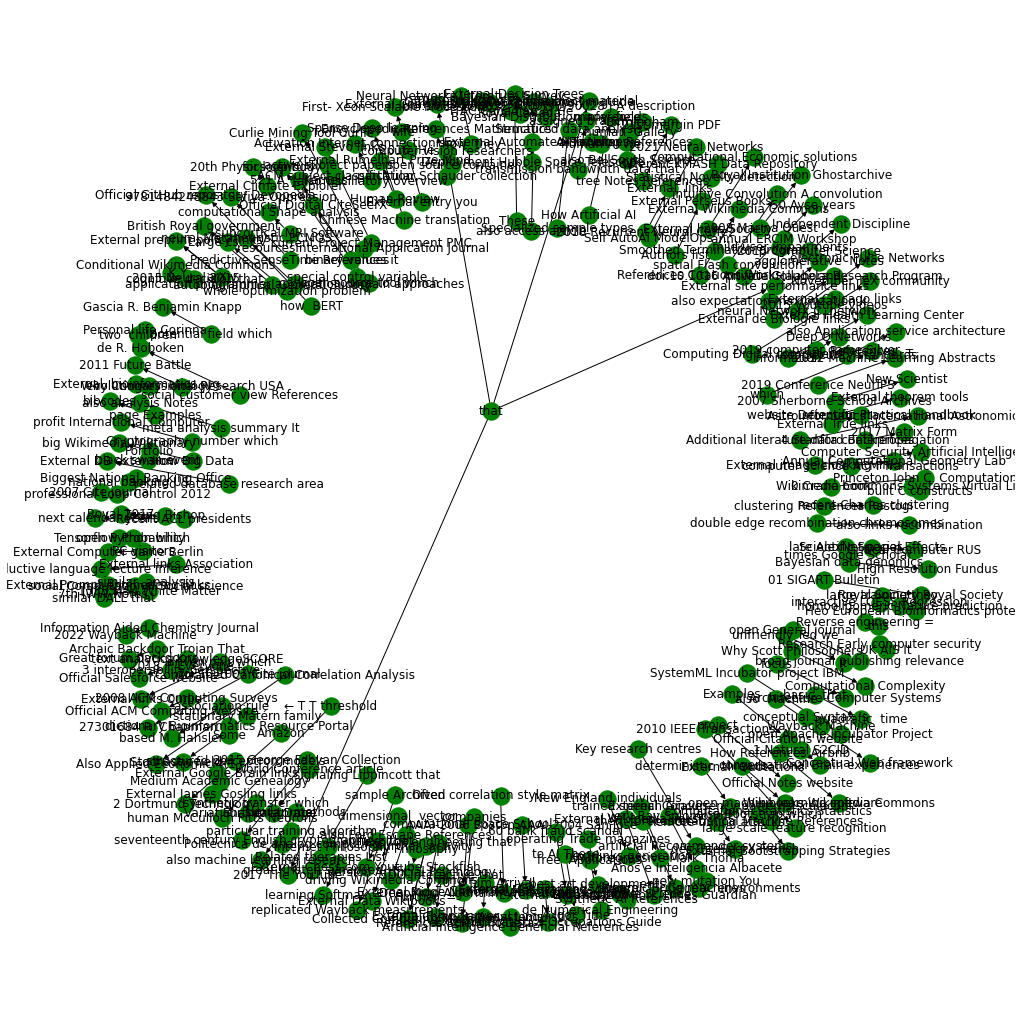

In [48]:
relations = [obtain_relation(j) for j in (data['text'])]

# subject extraction
subj = [j[0] for j in pairs_of_entities]

#object extraction
dobj = [k[1] for k in pairs_of_entities]

data_kgf = pd.DataFrame({'source':subj, 'target':dobj, 'edge':relations}) #dataframe di predicati tripletta predicato-verbo-oggetto

# Create KG from the dataframe
graph = ntx.from_pandas_edgelist(data_kgf, "source", "target",
                         edge_attr=True, create_using=ntx.MultiDiGraph())

# plotting the network
plt.figure(figsize=(14, 14))
posn = ntx.spring_layout(graph)
ntx.draw(graph, with_labels=True, node_color='green', edge_cmap=plt.cm.Blues, pos = posn)
plt.show()

In [49]:
#Most frequent relations extracted
#pd.Series(relations).value_counts()[:50]

Wordcloud Visualization :



(-0.5, 399.5, 199.5, -0.5)

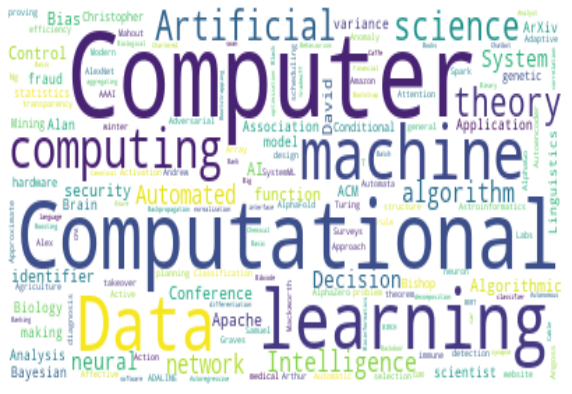

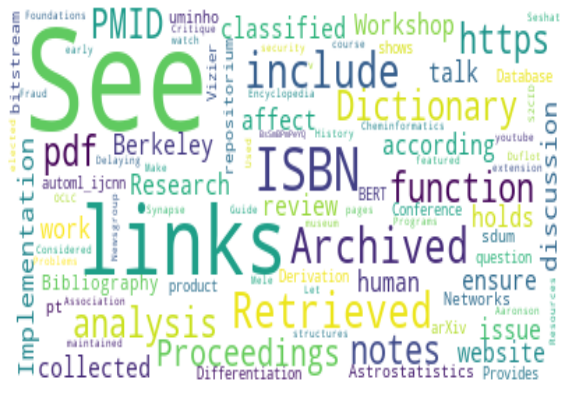

In [50]:
# Data Visualizaztion with Word Cloud for Categories of csv and relations of my KG
from wordcloud import WordCloud

data.head()
data.describe()
data.isna().sum()
data.dropna(inplace=True)
text = " ".join(page for page in data.page)
text_KG = " ".join(page for page in relations)

word_cloud = WordCloud(collocations= False, background_color='white').generate(text)
word_cloud_KG = WordCloud(collocations= False, background_color='white').generate(text_KG)

#Print Wordcloud of categories of csv file
print("Wordcloud Visualization :")
print()
plt.figure(figsize = (10,7))
plt.imshow(word_cloud, interpolation='bilinear', aspect='auto')
plt.axis('off')

#Print Wordcloud of categories of KG
plt.figure(figsize = (10,7))
plt.imshow(word_cloud_KG, interpolation='bilinear', aspect='auto')
plt.axis('off')

In [51]:
#Compute similarity metrics between subj and dobj
from sentence_transformers import SentenceTransformer, util

model = SentenceTransformer('all-MiniLM-L6-v2')

#take the first 10 source and first 10 target
w1 = subj[:10]
w2 = dobj[:10]

embedding_1 = model.encode(w1) #vectorize 
embedding_2 = model.encode(w2)

cosine_scores = util.cos_sim(embedding_1,embedding_2)

for i in range(len(w1)):
    print("\n{} \t \t {}".format(w1[i], w2[i]))
    print("Score : {:.4f}.".format(cosine_scores[i][i]))


External  Quotations 	 	 open machine learning software
Score : 0.1391.

AAAI-2006 Boston AAAI-2004 San Jose 	 	 External Machine links
Score : 0.0071.

active subject papers 	 	 ACM subject classification
Score : 0.4539.

2008 ACM Computing Surveys 	 	 Official ACM Computing website
Score : 0.7105.

particular training algorithm 	 	 Politécnica de analog computing
Score : 0.1528.

AI systems 	 	 Artificial Intelligence Beneficial References
Score : 0.5039.

unfriendly Ted we 	 	 it
Score : 0.1301.

also BellSouth Science 	 	 Birmingham
Score : 0.1313.

01 SIGART Bulletin 	 	 Royal Society Royal Society
Score : 0.2068.

autobiographical General Survey 	 	 British Royal government
Score : 0.0805.
